In [1]:
import numpy as np
import strax
import straxen
import pandas as pd
import nestpy   
import wfsim

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from multihist import Histdd, Hist1d
from scipy import stats
import RLdeconvolution

import json

In [2]:
#check straxen and wfsim version
print(straxen.__file__,'\n',wfsim.__file__)

/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/straxen/__init__.py 
 /home/changcai/.local/lib/python3.8/site-packages/wfsim/__init__.py


In [3]:
straxen.print_versions(('strax', 'straxen'))

Working on dali004.rcc.local with the following versions and installation paths:
python	v3.8.11	(default, Aug  3 2021, 15:09:35) [GCC 7.5.0]
strax	v0.16.1	/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/strax
straxen	v0.19.3	/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/straxen


选取数据，以run 21445，Ambe run为例，分析前5s内的数据
=====
首先解决信号同步问题

In [4]:
run_id = '021445'

In [5]:
st = straxen.contexts.xenonnt_online(_add_online_monitor_frontend=True)
st = straxen.contexts.xenonnt_online(output_folder='/home/changcai/scratch-midway2')
st.storage.append(strax.DataDirectory('/dali/lgrandi/xenonnt/nveto/processed/', readonly=True))


In [6]:
data = st.get_array('021445','raw_records',seconds_range=(0,1))

Loading raw_records: |          | 0.00 % [00:00<?]

In [7]:
len(data)

107690

如果只有raw_records available，则需要手动make ‘records’等需要的数据类型
`st.make(run_id, 'records')
st.make(run_id, 'peaks')`

选取第一秒的数据进行分析，需要peak以及records数据。通过peak找到饱和的信号以及该信号下饱和的通道。（选取饱和是因为信号较为明显，也可对别的peak进行同样处理，但前提是较大的信号，几十PE的信号不存在上升沿是否能对准的问题，但由于目前的peak给出的type还相对粗糙，仍然需要手动筛选）

In [8]:
st.make('021445','event_info')

In [9]:
events_info = st.get_array(run_id,'event_info')

Loading event_info: |          | 0.00 % [00:00<?]

In [56]:
selectdown = events_info['z']> -1 
selectup = events_info['z']< 0 
select = selectdown*selectup
topevents = events_info[select]
len(topevents)

2293

In [55]:
topevents['s1_endtime']-topevents['s1_time']

array([ 830, 1700, 2020, ..., 1410,  830, 1800])

(array([117., 108.,  92., 110., 129., 127., 129., 160., 349., 972.]),
 array([-9.99590516e-01, -8.99638236e-01, -7.99685955e-01, -6.99733675e-01,
        -5.99781394e-01, -4.99829113e-01, -3.99876833e-01, -2.99924552e-01,
        -1.99972257e-01, -1.00019984e-01, -6.76999989e-05], dtype=float32),
 <BarContainer object of 10 artists>)

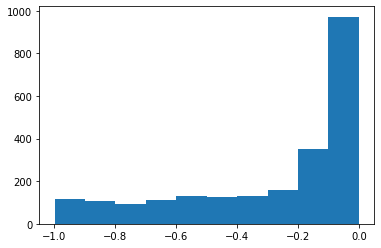

In [45]:
plt.hist(topevents['z'])

In [10]:
records = st.get_array(run_id,'records',seconds_range=(0,40))
peaks = st.get_array(run_id,'peaks',seconds_range=(0,40))

Loading records: |          | 0.00 % [00:00<?]

Loading peaks: |          | 0.00 % [00:00<?]

将所有存在饱和的信号列为`s_peak`

In [11]:
s_peak = peaks[peaks['n_saturated_channels']>0]

In [12]:
len(s_peak)

102

以整体peak时间在2000ns到3000ns之间初步筛选出Single Electron 事件，整体时间小于1000ns为S1事件

In [17]:
etoppeak = s_peak[(s_peak['length']*s_peak['dt']<3000)*(s_peak['length']*s_peak['dt']>2000)]
s1peak = s_peak[(s_peak['length']*s_peak['dt']<1000)]

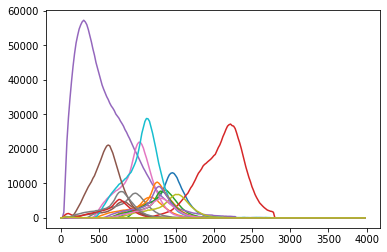

In [15]:
for i in etoppeak:
    plt.plot(np.arange(200)*i['dt'],i['data'])

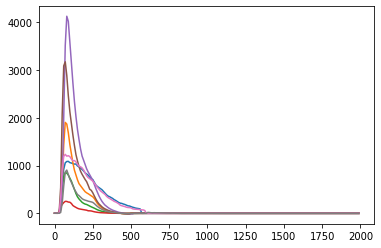

In [18]:
for i in s1peak:
    plt.plot(np.arange(200)*i['dt'],i['data'])

做图画出所有饱和peak图像，是否合理待讨论

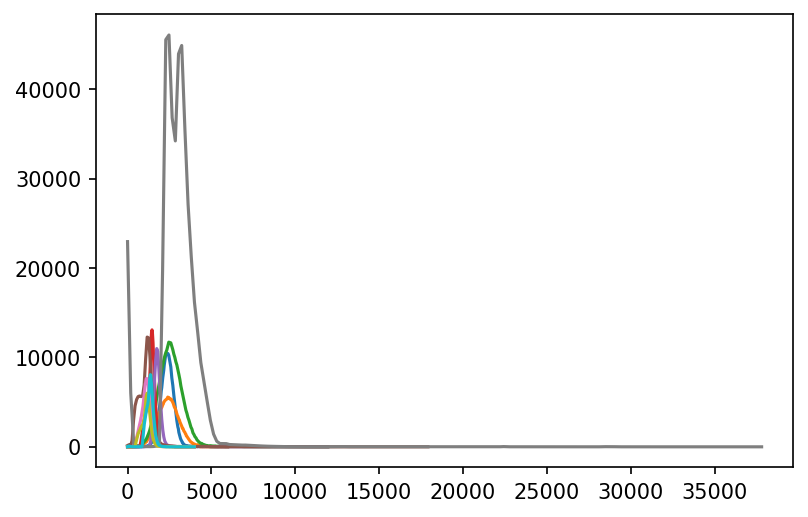

In [66]:
plt.figure(dpi = 150)
for i in s_peak[0:10]:
    plt.plot(np.arange(200)*i['dt'],i['data'])

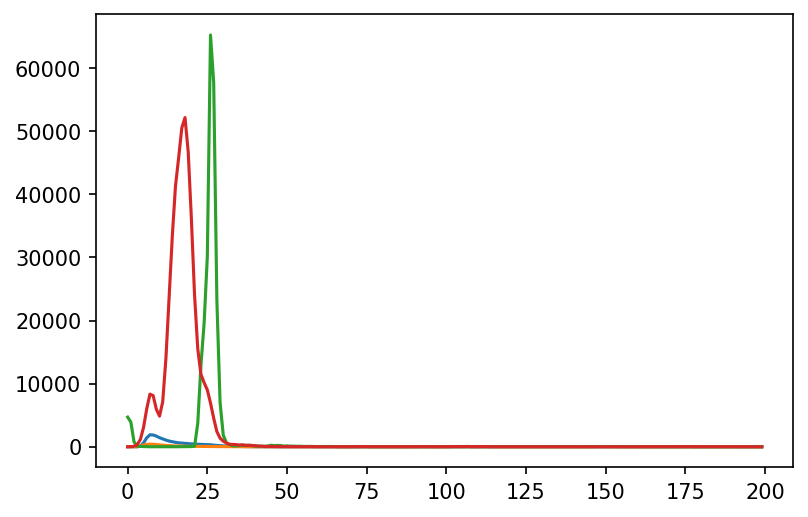

In [53]:
plt.figure(dpi = 150)
for i in s_peak:
    plt.plot(i['data'])

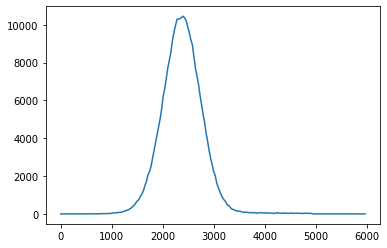

In [16]:
plt.plot(np.arange(200)*s_peak[0]['dt'],s_peak[0]['data'])

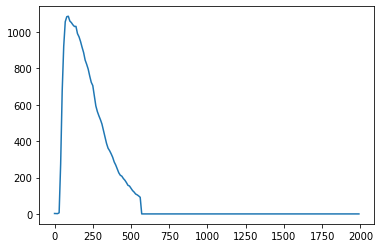

In [36]:
plt.plot(np.arange(200)*s_peak['dt'][13],s_peak['data'][13])

以下为原饱和通道信号输出代码，通过peak的start与end时间筛选records，再根据饱和通道序号整理出k通道的所有records`srecordsk`，将所有srecords拼接后peak中无records数据部分置零。最后为从records start time到endtime统一长度的kdata，同时按照ADCcount达到14400作为饱和的起点。

整体逻辑为‘筛选’+‘拼接’+‘饱和位置判定’，可以拆分为三个程序，对任意channel以及任意饱和判定条件都可以运行，如果没有饱和则将饱和时间位置设为`None'

首先根据时间筛选：

In [21]:
np.where(s_peak['saturated_channel'][13])

(array([213, 214, 226]),)

In [22]:
def records_selection(peak):
    #firstly findout the start and end time of the peaklet
    start, end = peak['time'],peak['time']+peak['length']*peak['dt']
    dt = 10
    #secondly find out the records in this interval,
    #If a peak starts between peakstart and peakend, or if it starts before peakstart but end after peakstart
    sequence = (records[:]['time']<end) * (records[:]['time'] > start) + (records[:]['time'] < start * (records[:]['time'] + 10*records[:]['length'] > start))
    records_in_peak = records[sequence]
    return records_in_peak

接下来将同一channel的records进行拼接，但需要注意`records['time']`并不以110个sample为间隔对齐,return一个总程度为(peak end - peak start)/10的numpy array。

In [23]:
def channelrecord(records,channel,start,end):
    #given all the records belong to the same peak, 
    #return the data from peak start to peak end, with records data on it
    #Firstly select the records belong to the same channel
    channelrecords = records[records['channel']==channel]
    #Then make the empty data array from peak start to peak end
    peaklength = int((end-start)/10)
    data = np.zeros(peaklength)
    for partrecord in channelrecords:
        index = int((partrecord['time']-start)/10)
        length = partrecord['length']
        #print(index,length,partrecord['data'])
        #print('****',end-partrecord['time'])
        if index<0:
            if peaklength >= length+index:
                data[:length+index]+=partrecord['data'][-index:length]
            else:
                data+=partrecord['data'][-index:peaklength-index]
        else:
            try:
                data[index:index+length]+=partrecord['data'][:length]
            except ValueError:
                recordzerolength = int((end-partrecord['time'])/10)
                data[index:]+=partrecord['data'][:recordzerolength]
    return data

在获得chennel record之后还需要进行ADC count到PE数的转换，具体可以参考issues

In [24]:
def adc_to_pe(data,channel,topemap):
    return data*topemap[channel]

通过函数将不同channel的pe data求和

In [25]:
def sumrecords(records,channellist,start,end,topemap):
    sumdata = np.zeros(int((end-start)/10))
    for channel in channellist:
        data = channelrecord(records,channel,start,end)
        sumdata+=adc_to_pe(data,channel,topemap)
    return sumdata

对饱和通道进行饱和位置判断：
目前是按照绝对ADC强度，后期可能改为将PMT累计读出信号大小带入考虑

In [26]:
def satpoint(channeldata,template):
    return np.where(channeldata>14400)[0][0]

In [57]:
def wfcorrection(channeldata,template):
    cut = satpoint(channeldata,template)
    channelsum = np.sum(channeldata[:cut])
    templatesum = np.sum(template[:cut])
    k = channelsum/templatesum
    satpart = k*template[cut:]
    reconstructed = np.concatenate((channeldata[:cut],satpart))
    return reconstructed,cut

对饱和通道，按照饱和位置之前的area大小比例，进行修正：

获得不同通道对应的ADC counts到PE的比值

In [28]:
gainrun="021445"
print("Will use gains from run {:s}".format(gainrun))
cmt=straxen.CorrectionsManagementServices()
topemap = cmt.get_pmt_gains(gainrun,'to_pe_model','ONLINE') #this would give you the actual gains 

Will use gains from run 021445


比较Top array与bottom array的波形，发现虽然都是不饱和，bottom更宽，结束更慢

In [81]:
i = 0
peakrecords = records_selection(s_peak[i])
start,end = s_peak[i]['time'],s_peak[i]['time']+s_peak[i]['length']*s_peak[i]['dt']
channeltop = np.arange(0,253)
channelbottom = np.arange(253,494)
databottom = sumrecords(peakrecords,channelbottom,start,end,topemap)
channelsaturate = s_peak['saturated_channel'][i][:253]
topus = channeltop[np.where(channelsaturate==0)]
tops = channeltop[np.where(channelsaturate!=0)]
usdatatop = sumrecords(peakrecords,topus,start,end,topemap)
bottomarea = np.sum(databottom)
toparea = np.sum(usdatatop)
k = bottomarea/toparea
#plt.plot(databottom,color='r')
#plt.plot(usdatatop*k)
#print(bottomarea)
template = usdatatop
for channel in np.where(s_peak['saturated_channel'][0])[0]:
    channeldata = channelrecord(peakrecords,channel,start,end)
    corrected = wfcorrection(channeldata,template)[0]
    cut = wfcorrection(channeldata,template)[1]
    #plt.figure(dpi = 150)
    #plt.plot(corrected)
    #plt.vlines(cut,0,np.max(corrected), linestyles ="dotted", colors ="k") 
    #plt.show()

70851.64003184531


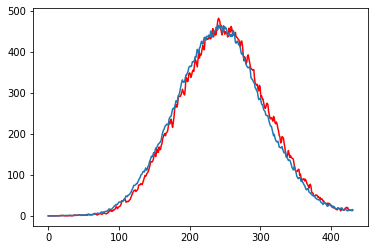

In [76]:
i = 1
peakrecords = records_selection(s_peak[i])
start,end = s_peak[i]['time'],s_peak[i]['time']+s_peak[i]['length']*s_peak[i]['dt']
channeltop = np.arange(0,253)
channelbottom = np.arange(253,494)
databottom = sumrecords(peakrecords,channelbottom,start,end,topemap)
channelsaturate = s_peak['saturated_channel'][i][:253]
topus = channeltop[np.where(channelsaturate==0)]
tops = channeltop[np.where(channelsaturate!=0)]
usdatatop = sumrecords(peakrecords,topus,start,end,topemap)
bottomarea = np.sum(databottom)
toparea = np.sum(usdatatop)
k = bottomarea/toparea
plt.plot(databottom,color='r')
plt.plot(usdatatop*k)
print(bottomarea)

67789.38067264389


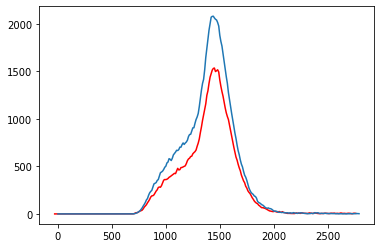

In [66]:
i = 3
peakrecords = records_selection(s_peak[i])
start,end = s_peak[i]['time'],s_peak[i]['time']+s_peak[i]['length']*s_peak[i]['dt']
channeltop = np.arange(0,253)
channelbottom = np.arange(253,494)
databottom = sumrecords(peakrecords,channelbottom,start,end,topemap)
channelsaturate = s_peak['saturated_channel'][i][:253]
topus = channeltop[np.where(channelsaturate==0)]
tops = channeltop[np.where(channelsaturate!=0)]
usdatatop = sumrecords(peakrecords,topus,start,end,topemap)
usdatatop = sumrecords(peakrecords,topus,start,end,topemap)
bottomarea = np.sum(databottom)
toparea = np.sum(usdatatop)
xrange = np.arange(start,end,10)-start
plt.plot(xrange-30,databottom,color='r')
plt.plot(xrange,usdatatop)
print(bottomarea)

713075.092506934 3448536.0 0.7932238223678297


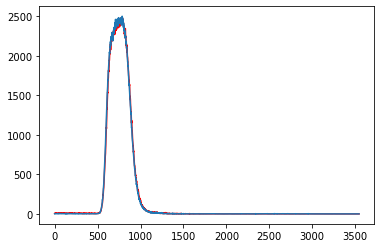

In [78]:
i = 14
peakrecords = records_selection(s_peak[i])
start,end = s_peak[i]['time'],s_peak[i]['time']+s_peak[i]['length']*s_peak[i]['dt']
channeltop = np.arange(0,253)
channelbottom = np.arange(253,494)
databottom = sumrecords(peakrecords,channelbottom,start,end,topemap)
channelsaturate = s_peak['saturated_channel'][i][:253]
topus = channeltop[np.where(channelsaturate==0)]
tops = channeltop[np.where(channelsaturate!=0)]
usdatatop = sumrecords(peakrecords,topus,start,end,topemap)
bottomarea = np.sum(databottom)
toparea = np.sum(usdatatop)
k = bottomarea/toparea
plt.plot(databottom,color='r')
plt.plot(usdatatop*k)
print(bottomarea,s_peak[i]['area'],1-bottomarea/s_peak[i]['area'])

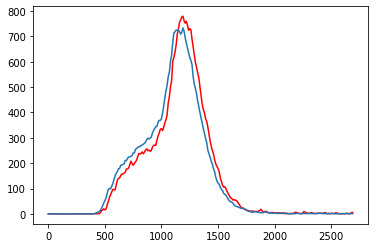

37511.67448181659 155932.17 0.7594359519863092


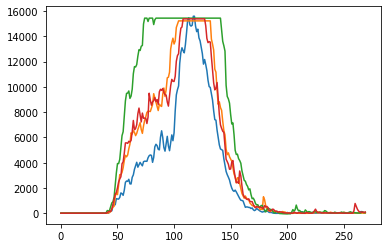

In [82]:
i = 8
peakrecords = records_selection(s_peak[i])
start,end = s_peak[i]['time'],s_peak[i]['time']+s_peak[i]['length']*s_peak[i]['dt']
channeltop = np.arange(0,253)
channelbottom = np.arange(253,494)
databottom = sumrecords(peakrecords,channelbottom,start,end,topemap)
channelsaturate = s_peak['saturated_channel'][i][:253]
topus = channeltop[np.where(channelsaturate==0)]
tops = channeltop[np.where(channelsaturate!=0)]
usdatatop = sumrecords(peakrecords,topus,start,end,topemap)
bottomarea = np.sum(databottom)
toparea = np.sum(usdatatop)
k = bottomarea/toparea
xrange = np.arange(start,end,10)-start
plt.plot(xrange,databottom,color='r')
plt.plot(xrange,usdatatop*k)
plt.show()
for k in tops:
    plt.plot(channelrecord(peakrecords,k,start,end))
print(bottomarea,s_peak[i]['area'],1-bottomarea/s_peak[i]['area'])

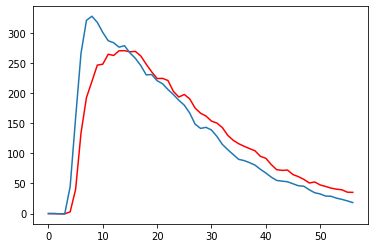

7586.171067628078


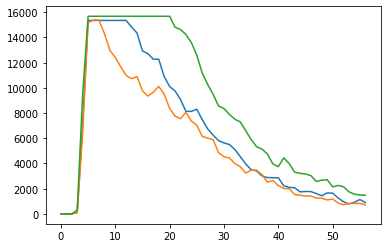

In [94]:
i = 13
peakrecords = records_selection(s_peak[i])
start,end = s_peak[i]['time'],s_peak[i]['time']+s_peak[i]['length']*s_peak[i]['dt']
channeltop = np.arange(0,253)
channelbottom = np.arange(253,494)
databottom = sumrecords(peakrecords,channelbottom,start,end,topemap)
channelsaturate = s_peak['saturated_channel'][i][:253]
topus = channeltop[np.where(channelsaturate==0)]
tops = channeltop[np.where(channelsaturate!=0)]
usdatatop = sumrecords(peakrecords,topus,start,end,topemap)
bottomarea = np.sum(databottom)
toparea = np.sum(usdatatop)
k = bottomarea/toparea
plt.plot(databottom,color='r')
plt.plot(usdatatop*k)
plt.show()
for k in tops:
    plt.plot(channelrecord(peakrecords,k,start,end))
print(bottomarea)

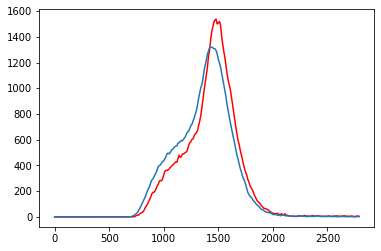

67789.38067264389


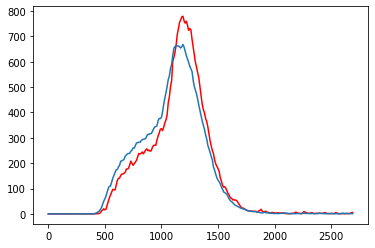

37511.67448181659


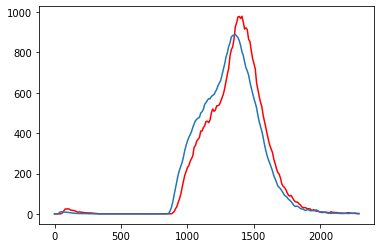

42659.55259541888


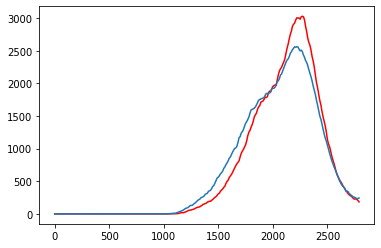

193180.82482118998


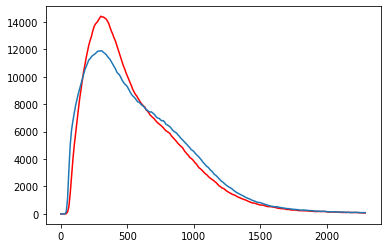

927974.759378341


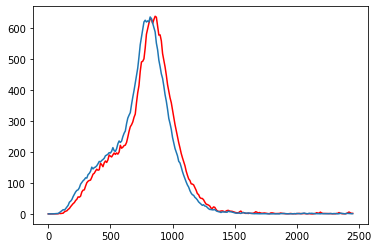

27761.243614468724


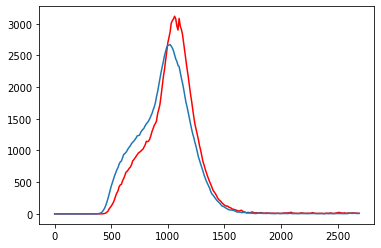

133049.9101056168


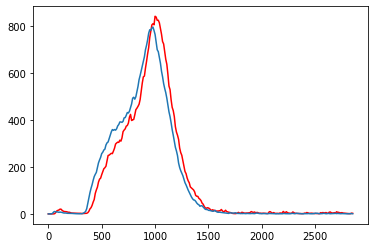

39915.46762543265


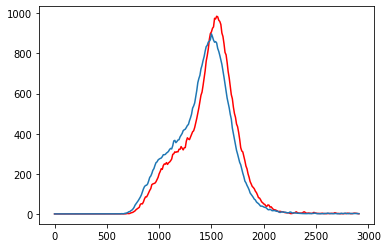

48256.70311063994


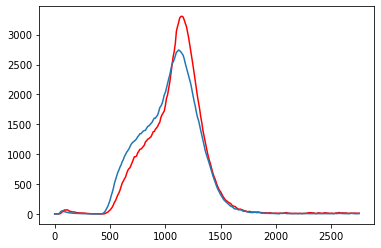

153147.42614404298


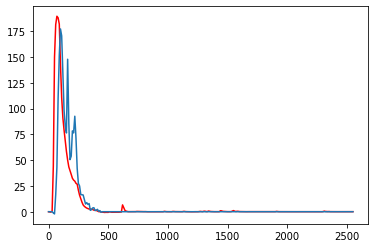

1916.7586808716878


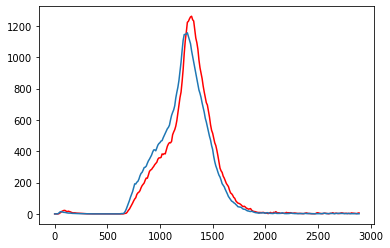

51683.09039584361


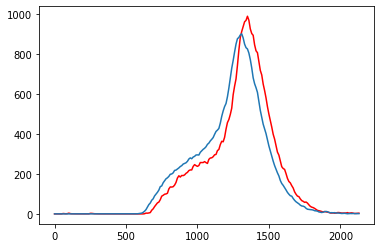

38919.23434139136


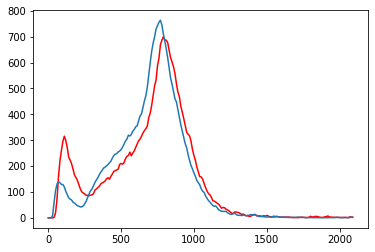

30769.020358517766


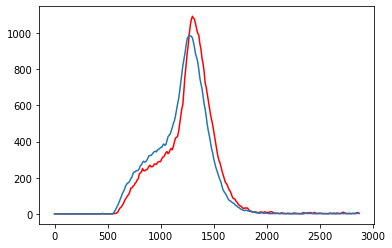

45470.09811436199


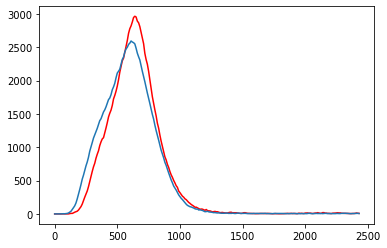

122647.90403978433


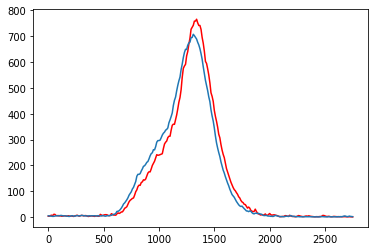

36061.66505059693


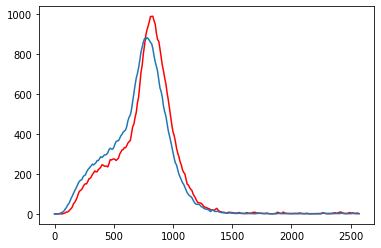

41918.28004125133


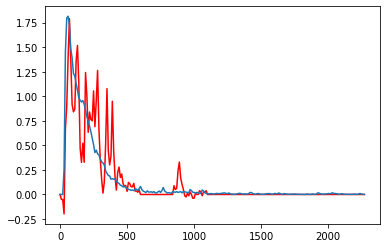

31.963585268706083


In [110]:
for i in range(len(etoppeak)):
    peakrecords = records_selection(etoppeak[i])
    start,end = etoppeak[i]['time'],etoppeak[i]['time']+etoppeak[i]['length']*etoppeak[i]['dt']
    channeltop = np.arange(0,253)
    channelbottom = np.arange(253,494)
    databottom = sumrecords(peakrecords,channelbottom,start,end,topemap)
    channelsaturate = s_peak['saturated_channel'][i][:253]
    topus = channeltop[np.where(channelsaturate==0)]
    tops = channeltop[np.where(channelsaturate!=0)]
    usdatatop = sumrecords(peakrecords,topus,start,end,topemap)
    usdatatop = sumrecords(peakrecords,topus,start,end,topemap)
    bottomarea = np.sum(databottom)
    toparea = np.sum(usdatatop)
    k = bottomarea/toparea
    xrange = np.arange(start,end,10)-start
    plt.plot(xrange,databottom,color='r')
    plt.plot(xrange,usdatatop*k)
    plt.show()
    print(bottomarea)

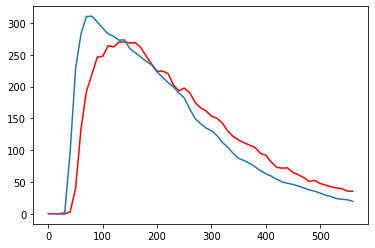

7586.171067628078


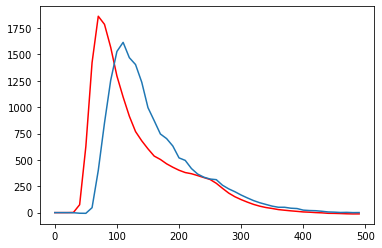

18103.571193185635


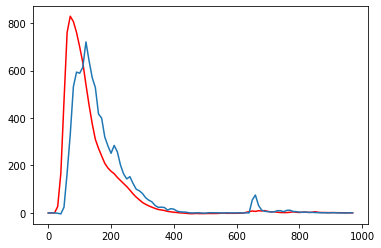

9193.294500255026


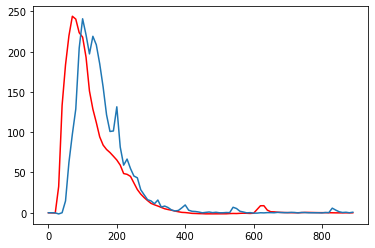

2935.197152905166


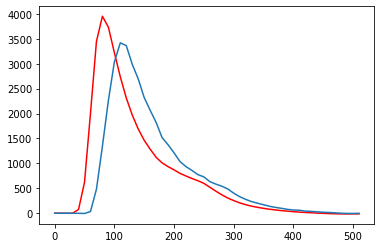

38829.24681026116


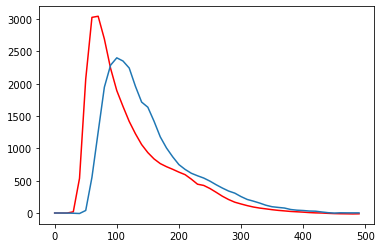

29369.25445057638


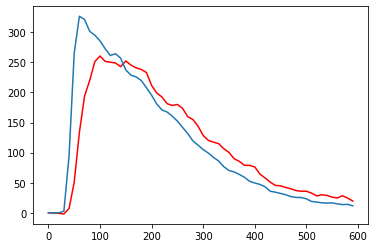

6887.821403353475


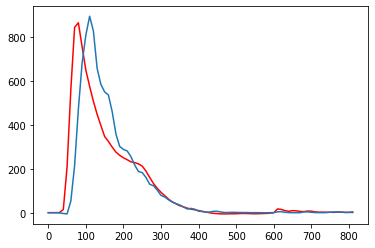

9809.0002997173


In [83]:
for i in range(len(s1peak)):
    peakrecords = records_selection(s1peak[i])
    start,end = s1peak[i]['time'],s1peak[i]['time']+s1peak[i]['length']*s1peak[i]['dt']
    channeltop = np.arange(0,253)
    channelbottom = np.arange(253,494)
    databottom = sumrecords(peakrecords,channelbottom,start,end,topemap)
    channelsaturate = s_peak['saturated_channel'][i][:253]
    topus = channeltop[np.where(channelsaturate==0)]
    tops = channeltop[np.where(channelsaturate!=0)]
    usdatatop = sumrecords(peakrecords,topus,start,end,topemap)
    bottomarea = np.sum(databottom)
    toparea = np.sum(usdatatop)
    k = bottomarea/toparea
    xrange = np.arange(start,end,10)-start
    plt.plot(xrange,databottom,color='r')
    plt.plot(xrange,usdatatop*k)
    plt.show()
    print(bottomarea)

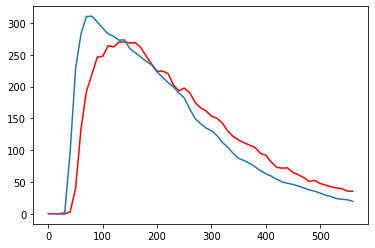

7586.171067628078


In [84]:
i = 0
peakrecords = records_selection(s1peak[i])
start,end = s1peak[i]['time'],s1peak[i]['time']+s1peak[i]['length']*s1peak[i]['dt']
channeltop = np.arange(0,253)
channelbottom = np.arange(253,494)
databottom = sumrecords(peakrecords,channelbottom,start,end,topemap)
channelsaturate = s_peak['saturated_channel'][i][:253]
topus = channeltop[np.where(channelsaturate==0)]
tops = channeltop[np.where(channelsaturate!=0)]
usdatatop = sumrecords(peakrecords,topus,start,end,topemap)
bottomarea = np.sum(databottom)
toparea = np.sum(usdatatop)
k = bottomarea/toparea
xrange = np.arange(start,end,10)-start
plt.plot(xrange,databottom,color='r')
plt.plot(xrange,usdatatop*k)
plt.show()
print(bottomarea)

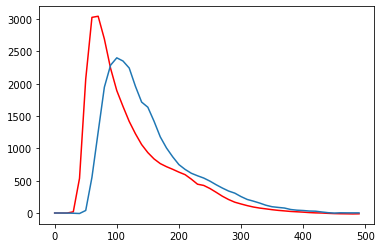

29369.25445057638


In [82]:
i = 5
peakrecords = records_selection(s1peak[i])
start,end = s1peak[i]['time'],s1peak[i]['time']+s1peak[i]['length']*s1peak[i]['dt']
channeltop = np.arange(0,253)
channelbottom = np.arange(253,494)
databottom = sumrecords(peakrecords,channelbottom,start,end,topemap)
channelsaturate = s_peak['saturated_channel'][i][:253]
topus = channeltop[np.where(channelsaturate==0)]
tops = channeltop[np.where(channelsaturate!=0)]
usdatatop = sumrecords(peakrecords,topus,start,end,topemap)
usdatatop = sumrecords(peakrecords,topus,start,end,topemap)
bottomarea = np.sum(databottom)
toparea = np.sum(usdatatop)
k = bottomarea/toparea
xrange = np.arange(start,end,10)-start
plt.plot(xrange,databottom,color='r')
plt.plot(xrange,usdatatop*k)
plt.show()
print(bottomarea)

In [45]:
def saturated_channel_data(peaklets,i,plot = True):
    #for a given peaklet,return the data of saturated channels,[channel, saturatestart time (1 sigma),time,data]
    #i is the index of the peaklets
    if peaklets[i]['n_saturated_channels'] == 0:
        return None
    #firstly findout the start and end time of the peaklet
    start, end = peaklets[i]['time'],peaklets[i]['time']+peaklets[i]['length']*peaklets[i]['dt']
    #secondly find out the records in this interval
    sequence = (records[:]['time']<end) * (records[:]['time'] > start)
    records_in_peak = records[sequence]
    #then find oud which channel saturated
    schannel = np.where(peaklets[i]['saturated_channel']>0)
    saturatepeaklink = []
    dt = 10
    for k in schannel[0]:
        srecordsk = records_in_peak[records_in_peak['channel'] == k]
        channelstarttime = srecordsk[0]['time']
        startzerotime = channelstarttime - start 
        startzerodata = np.zeros(int(startzerotime/dt))
        length = int((end-start)/dt)
        kdata = np.concatenate((startzerodata,np.concatenate(srecordsk['data'][:])))
        ktime = np.arange(start,end,dt)
        if len(kdata)<length:
            kdata = np.concatenate((kdata,np.zeros(length-len(kdata))))
        else:
            kdata = kdata[:length]
        if plot == True:
            plt.plot(ktime-start, kdata)
        #print(kdata)
        kcuttime = np.where(kdata>14400)[0][0]*dt + start
        saturatepeak_k = [k,kcuttime,ktime,kdata,srecordsk]
        saturatepeaklink.append(saturatepeak_k)
    return saturatepeaklink

In [46]:
def specific_channel_data(peaklets,i,channelnumber):
    #for a given peaklet,return the data of specific channels,return time,
    #i is the index of the peaklets
    #firstly findout the start and end time of the peaklet
    start, end = peaklets[i]['time'],peaklets[i]['time']+peaklets[i]['length']*peaklets[i]['dt']
    dt = 10
    #secondly find out the records in this interval
    sequence = (records[:]['time']<end) * (records[:]['time'] > start) + (records[:]['time'] < start * (records[:]['time'] + 10*records[:]['length'] > start))
    records_in_peak = records[sequence]
    peaklink = []
    for k in channelnumber:
        recordsk = records_in_peak[records_in_peak['channel'] == k]
        #the start time of the signal in the channel
        if len(recordsk) == 0:
            continue
        channelstarttime = recordsk[0]['time']
        startzerotime = channelstarttime - start
        if startzerotime >= 0:
            startzerodata = np.zeros(int(startzerotime/dt))
            kdata = np.concatenate((startzerodata,np.concatenate(recordsk['data'][:])))
        else:
            recordsoutpeak = int(-startzerotime/dt)
            kdata = np.concatenate(recordsk['data'][:])[recordsoutpeak:]
        length = int((end-start)/dt)
        ktime = np.arange(start,end,dt)
        if len(kdata)<length:
            kdata = np.concatenate((kdata,np.zeros(length-len(kdata))))
        else:
            kdata = kdata[:length]
        peaklink.append([kdata,ktime])
    return peaklink,recordsinpeak

In [47]:
def unsaturated_channel_data(peaklets,i):
    #for a given peaklet,return the data of unsaturated channels,return sumdata, time,
    #i is the index of the peaklets
    #firstly findout the start and end time of the peaklet
    start, end = peaklets[i]['time'],peaklets[i]['time']+peaklets[i]['length']*peaklets[i]['dt']
    dt = 10
    #secondly find out the records in this interval
    sequence = (records[:]['time']<end) * (records[:]['time'] > start) + (records[:]['time'] < start * (records[:]['time'] + 10*records[:]['length'] > start))
    records_in_peak = records[sequence]
    #then find oud which channel unsaturated
    uschannel = np.where(peaklets[i]['saturated_channel'] == 0)
    sumdata = np.zeros(int((end-start)/dt))
    for k in uschannel[0]:
        usrecordsk = records_in_peak[records_in_peak['channel'] == k]
        #the start time of the signal in the channel
        if len(usrecordsk) == 0:
            continue
        channelstarttime = usrecordsk[0]['time']
        startzerotime = channelstarttime - start
        if startzerotime >= 0:
            startzerodata = np.zeros(int(startzerotime/dt))
            kdata = np.concatenate((startzerodata,np.concatenate(usrecordsk['data'][:])))
        else:
            recordsoutpeak = int(-startzerotime/dt)
            kdata = np.concatenate(usrecordsk['data'][:])[recordsoutpeak:]
        length = int((end-start)/dt)
        ktime = np.arange(start,end,dt)
        if len(kdata)<length:
            kdata = np.concatenate((kdata,np.zeros(length-len(kdata))))
        else:
            kdata = kdata[:length]
        sumdata += kdata
    return sumdata,ktime

In [48]:
def satcorrect(saturatechannel,otherdata):
    #saturatechannel = [channelnumber,saturatetime,time,data]
    dt = 10
    channel, saturatetime, time, data = saturatechannel[0], saturatechannel[1],saturatechannel[2],saturatechannel[3]
    satsamples = int((saturatetime - time[0])/dt)
    othersum = np.sum(otherdata[:satsamples])
    channelunsatsum = np.sum(data[:satsamples])
    k = channelunsatsum/othersum
    channelunsatdata = data[:satsamples]
    correctdata = otherdata*k
    aftercorrection = np.concatenate((channelunsatdata,correctdata[satsamples:]))
    return aftercorrection,k

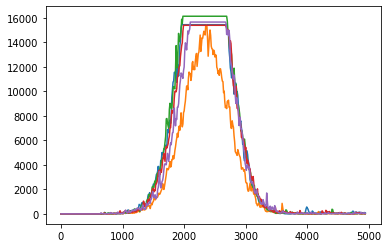

In [49]:
schannels = saturated_channel_data(s_peak,0,plot = True)

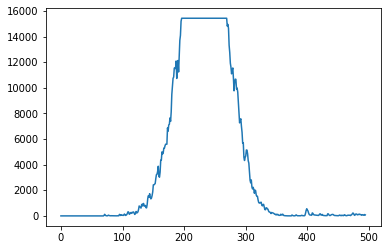

In [52]:
plt.plot(schannels[0][3])

In [55]:
s_peak[0]['time']

1622864738374146960

In [54]:
schannels[0][4]

array([(1622864738374147160, 110, 10, 13, 1054, 0,    8475, 2, 15439.775, 1.5081031, 0, [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,    -2,    -2,    39,   125,    55,    20,     9,     7,    14,    57,    37,    18,     9,     7,    13,    10,     8,     8,     8,     9,     5,     9,     4,     4,     3,     3,    11,   118,    72,    33,    91,    54,    55,    34,    58,   147,    92,    36,    64,   107,   222,   326,   282,   124,   169,   249,   264,   197,   284,   273,   308,   192,   112,   203,   343,   233,   251,   317,   494,   774,   716,   651]),
       (1622864738374148260, 110, 10, 13, 1054, 1, 1034706, 2, 15439.775, 1.5081031, 0, [  610,   874,   917,   766,   972,   834,   764,  

In [41]:
ussum = unsaturated_channel_data(s_peak,0)

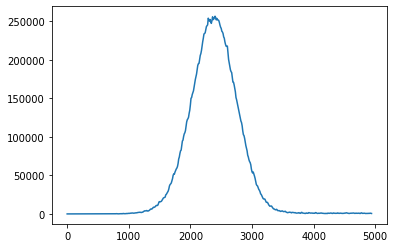

In [44]:
plt.plot(ussum[1]-ussum[1][0],ussum[0])

In [60]:
peaks[400]['area']

632013.3

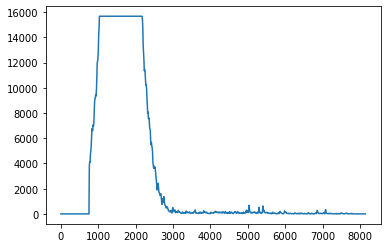

In [73]:
saturatechannel = saturated_channel_data(peaks,400,plot = True)

In [72]:
other = unsaturated_channel_data(peaks,400)[0]

In [75]:
aftcorrected = satcorrect(saturatechannel[0],other)

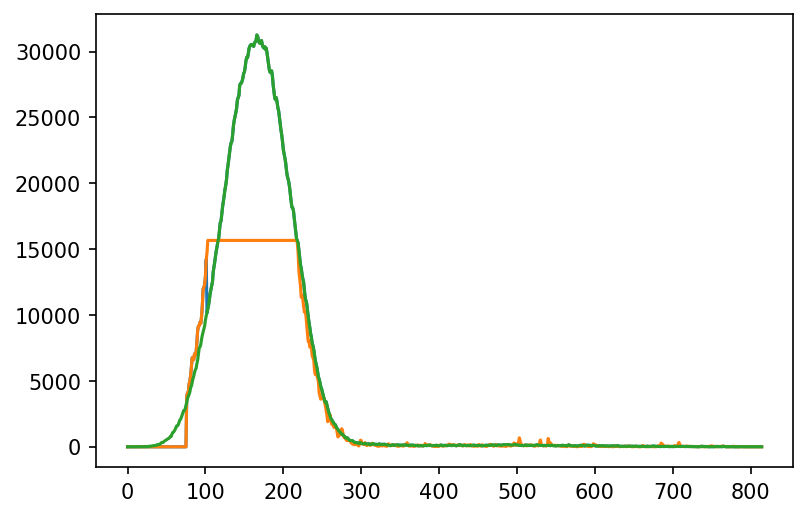

In [80]:
plt.figure(dpi = 150)
plt.plot(aftcorrected[0])
plt.plot(saturatechannel[0][3])
plt.plot(aftcorrected[1]*other)

In [86]:
np.where(peaks[400]['saturated_channel']>0)

(array([15]),)

In [141]:
channeldata = specific_channel_data(peaks,400,[12,13,14,15,16,17,18,100,300])

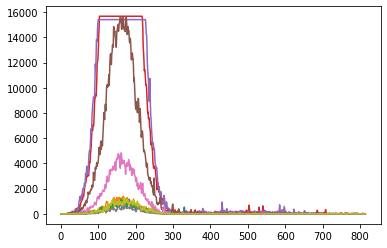

In [142]:
for data in channeldata:
    plt.plot(data[0])

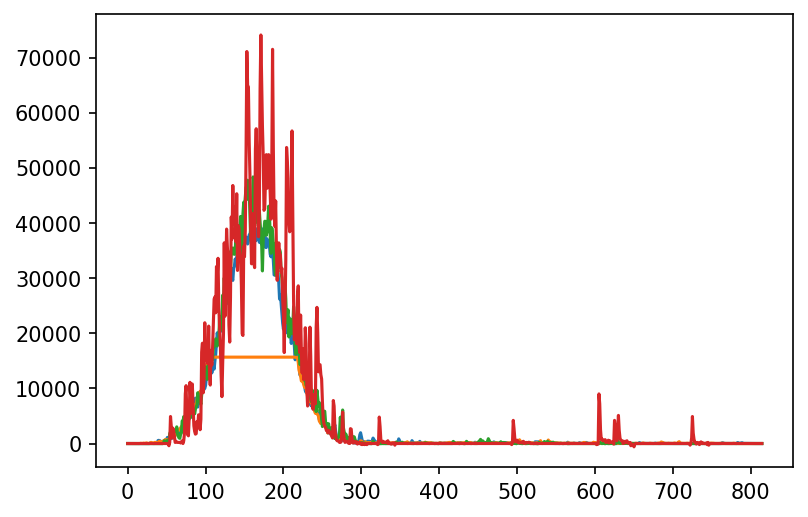

In [145]:
plt.figure(dpi = 150)
plt.plot(channeldata[5][0]*2.5)
plt.plot(channeldata[3][0])
plt.plot(channeldata[6][0]*10)
plt.plot(channeldata[7][0]*100)

In [116]:
channeldata[2][0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     2,     5,    45,
          17,     6,     2,     1,    -1,     1,     1,     3,    -2,
          -1,    27,    84,    35,    71,    51,    98,   124,   114,
         148,   185,   359,   361,   185,   192,   180,   188,   378,
         266,   289,   421,   778,  1076,  1183,  1375,  1201,  1043,
        1134,  1469,  1327,  1606,  1902,  1990,  1957,  2054,  2030,
        2416,  2183,  2509,  3197,  3050,  3047,  3771,  3705,  3153,
        3102,  3458,  4153,  4702,  4925,  5079,  5151,  5717,  6454,
        6750,  6559,  7677,  8172,  8635,  8902,  9264,  9246,  9165,
        9211, 10629, 11888, 11425, 12370, 13815, 13745, 13676, 14803,
       15197, 15400, 15400, 15400, 15400, 15400, 15400, 15400, 15400,
       15400, 15400, 15400, 15400, 15400, 15400, 15400, 15400, 15400,
       15400, 15400, 15400, 15400, 15400, 15400, 15400, 15400, 15400,
       15400, 15400,